### Multi GPU Training

### UNET Arch - 1 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.filters import threshold_otsu


#### DataSet Class

In [ ]:
# Custom Dataset Class
class FaceSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            
        return image, mask

#### U-Net Architecture

In [ ]:
# Fixed U-Net Architecture - Now removing the sigmoid from the model
class FastUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(FastUNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        # Reduced number of filters
        self.enc1 = conv_block(in_channels, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(64, 128)
        self.pool3 = nn.MaxPool2d(2)
        
        self.bottleneck = conv_block(128, 256)
        
        self.upconv3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = conv_block(256, 128)  # 256 = 128 (from upconv3) + 128 (from enc3)
        
        self.upconv2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = conv_block(128, 64)   # 128 = 64 (from upconv2) + 64 (from enc2)
        
        self.upconv1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = conv_block(64, 32)    # 64 = 32 (from upconv1) + 32 (from enc1)
        
        self.final = nn.Conv2d(32, out_channels, 1)
        
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool3(enc3))
        
        # Decoder - Complete decoder path with all upsampling steps
        dec3 = self.upconv3(bottleneck)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        
        # Removed sigmoid to use with BCEWithLogitsLoss
        return self.final(dec1)


### UNET Arch - 2 

#### Module imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from sklearn.model_selection import KFold
from skimage.filters import threshold_otsu

#### Loading the Dataset

In [ ]:
# Custom Dataset Class
class FaceSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            
        return image, mask

#### Attention Gate Module

In [ ]:
# Attention Gate Module
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_l, 1),
            nn.BatchNorm2d(F_l)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_l, 1),
            nn.BatchNorm2d(F_l)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_l, 1, 1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

#### Enhanced UNET Architecture

In [ ]:
# Enhanced U-Net Architecture
class EnhancedUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(EnhancedUNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        # Encoder
        self.enc1 = conv_block(in_channels, 48)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(48, 96)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(96, 192)
        self.pool3 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = conv_block(192, 384)
        
        # Decoder with Attention Gates
        self.upconv3 = nn.ConvTranspose2d(384, 192, 2, stride=2)
        self.attn3 = AttentionGate(192, 192)
        self.dec3 = conv_block(384, 192)
        
        self.upconv2 = nn.ConvTranspose2d(192, 96, 2, stride=2)
        self.attn2 = AttentionGate(96, 96)
        self.dec2 = conv_block(192, 96)
        
        self.upconv1 = nn.ConvTranspose2d(96, 48, 2, stride=2)
        self.attn1 = AttentionGate(48, 48)
        self.dec1 = conv_block(96, 48)
        
        self.final = nn.Conv2d(48, out_channels, 1)
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool3(enc3))
        
        # Decoder
        dec3 = self.upconv3(bottleneck)
        dec3 = self.attn3(dec3, enc3)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = self.attn2(dec2, enc2)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = self.attn1(dec1, enc1)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        
        return self.final(dec1)

#### Loss Function

In [ ]:
# Combined Loss Function
class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=0.7):
        super().__init__()
        self.bce_weight = bce_weight
        self.bce = nn.BCEWithLogitsLoss()
        
    def dice_loss(self, pred, target):
        smooth = 1.
        pred = torch.sigmoid(pred)
        intersection = (pred * target).sum()
        return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
        
    def forward(self, pred, target):
        return self.bce_weight * self.bce(pred, target) + \
               (1 - self.bce_weight) * self.dice_loss(pred, target)

#### Configuration

In [ ]:
# Configuration
# image_dir = '/kaggle/input/msdf-mskdataset/face_crop'
# mask_dir = '/kaggle/input/msdf-mskdataset/face_crop_segmentation'
image_dir = '../../../dataset/MSDF/1/face_crop'
mask_dir = '../../../dataset/MSDF/1/face_crop_segmentation'
batch_size = 32
input_size = 128
epochs = 30
lr = 0.001
patience = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
k_folds = 3

# Data Augmentation
image_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((input_size, input_size), transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

# Metrics Calculation
def calculate_metrics(pred, target):
    pred = torch.sigmoid(pred)
    pred_bin = (pred > 0.5).float()
    
    # IoU
    intersection = (pred_bin * target).sum()
    union = pred_bin.sum() + target.sum() - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    
    # Dice
    dice = (2. * intersection + 1e-6) / (pred_bin.sum() + target.sum() + 1e-6)
    
    return iou.item(), dice.item()

# Traditional Method
def otsu_segmentation(image_path, target_size=(128, 128)):
    image = Image.open(image_path).convert('L')
    image = image.resize(target_size)
    img_array = np.array(image)
    threshold = threshold_otsu(img_array)
    binary = torch.tensor(img_array > threshold).float()
    return binary.unsqueeze(0)
# Initialize dataset
dataset = FaceSegmentationDataset(image_dir, mask_dir, image_transform, mask_transform)
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

#### Training and Evaluation

In [ ]:
# Training and Evaluation
final_metrics = {'unet': {'iou': [], 'dice': []}, 'traditional': {'iou': [], 'dice': []}}

for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f'\n{"="*30}\nFold {fold+1}/{k_folds}\n{"="*30}')
    
    # Data loaders
    train_subsampler = SubsetRandomSampler(train_ids)
    val_subsampler = SubsetRandomSampler(val_ids)
    
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler,
                            pin_memory=True, num_workers=4, persistent_workers=True)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler,
                          pin_memory=True, num_workers=4, persistent_workers=True)

    # Model setup
    model = EnhancedUNet().to(device)
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    
    criterion = CombinedLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
    
    best_val_loss = float('inf')
    early_stop_counter = 0
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        # Training phase
        for images, masks in train_loader:
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_iou, val_dice = 0.0, 0.0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images)
                
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                
                iou, dice = calculate_metrics(outputs, masks)
                val_iou += iou * images.size(0)
                val_dice += dice * images.size(0)
        
        # Calculate metrics
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        val_iou /= len(val_ids)
        val_dice /= len(val_ids)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), f'{checkpoint_dir}/best_fold{fold+1}.pth')
        else:
            early_stop_counter += 1
            
        # Print epoch summary
        print(f'Epoch {epoch+1:02d}/{epochs} | '
              f'Train Loss: {train_loss:.4f} | '
              f'Val Loss: {val_loss:.4f} | '
              f'IoU: {val_iou:.4f} | '
              f'Dice: {val_dice:.4f} | '
              f'LR: {optimizer.param_groups[0]["lr"]:.2e}')
        
        # Early stopping
        if early_stop_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    # Load best model for evaluation
    model.load_state_dict(torch.load(f'{checkpoint_dir}/best_fold{fold+1}.pth'))
    
    # Final evaluation
    model.eval()
    fold_iou, fold_dice = 0.0, 0.0
    trad_iou, trad_dice = 0.0, 0.0
    
    with torch.no_grad():
        for idx in val_ids:
            # U-Net evaluation
            image, mask = dataset[idx]
            image = image.unsqueeze(0).to(device)
            pred = model(image)
            iou, dice = calculate_metrics(pred, mask.unsqueeze(0).to(device))
            fold_iou += iou
            fold_dice += dice
            
            # Traditional method evaluation
            img_path = os.path.join(image_dir, dataset.image_files[idx])
            true_mask = mask.squeeze().cpu()
            pred_mask = otsu_segmentation(img_path)
            trad_iou += calculate_metrics(torch.tensor(pred_mask).unsqueeze(0), true_mask.unsqueeze(0))[0]
            trad_dice += calculate_metrics(torch.tensor(pred_mask).unsqueeze(0), true_mask.unsqueeze(0))[1]
    
    # Store metrics
    final_metrics['unet']['iou'].append(fold_iou/len(val_ids))
    final_metrics['unet']['dice'].append(fold_dice/len(val_ids))
    final_metrics['traditional']['iou'].append(trad_iou/len(val_ids))
    final_metrics['traditional']['dice'].append(trad_dice/len(val_ids))
    
    print(f'\nFold {fold+1} Results:')
    print(f'U-Net:    IoU: {final_metrics["unet"]["iou"][-1]:.4f} | Dice: {final_metrics["unet"]["dice"][-1]:.4f}')
    print(f'Traditional: IoU: {final_metrics["traditional"]["iou"][-1]:.4f} | Dice: {final_metrics["traditional"]["dice"][-1]:.4f}')


#### Final Summary

In [2]:

# Final Summary
print('\n\nFinal Cross-Validation Results:')
print('U-Net Performance:')
print(f'Mean IoU: {np.mean(final_metrics["unet"]["iou"]):.4f} (±{np.std(final_metrics["unet"]["iou"]):.4f})')
print(f'Mean Dice: {np.mean(final_metrics["unet"]["dice"]):.4f} (±{np.std(final_metrics["unet"]["dice"]):.4f})')

print('\nTraditional Method Performance:')
print(f'Mean IoU: {np.mean(final_metrics["traditional"]["iou"]):.4f} (±{np.std(final_metrics["traditional"]["iou"]):.4f})')
print(f'Mean Dice: {np.mean(final_metrics["traditional"]["dice"]):.4f} (±{np.std(final_metrics["traditional"]["dice"]):.4f})')


Fold 1/3
Epoch 01/30 | Train Loss: 0.4688 | Val Loss: 0.3202 | IoU: 0.6366 | Dice: 0.7777 | LR: 1.00e-03
Epoch 02/30 | Train Loss: 0.3102 | Val Loss: 0.3016 | IoU: 0.6635 | Dice: 0.7975 | LR: 1.00e-03
Epoch 03/30 | Train Loss: 0.2944 | Val Loss: 0.2971 | IoU: 0.6533 | Dice: 0.7901 | LR: 1.00e-03
Epoch 04/30 | Train Loss: 0.2887 | Val Loss: 0.2833 | IoU: 0.6755 | Dice: 0.8061 | LR: 1.00e-03
Epoch 05/30 | Train Loss: 0.2854 | Val Loss: 0.2849 | IoU: 0.6745 | Dice: 0.8053 | LR: 1.00e-03
Epoch 06/30 | Train Loss: 0.2810 | Val Loss: 0.2852 | IoU: 0.6646 | Dice: 0.7983 | LR: 1.00e-03
Epoch 07/30 | Train Loss: 0.2787 | Val Loss: 0.2780 | IoU: 0.6754 | Dice: 0.8061 | LR: 1.00e-03
Epoch 08/30 | Train Loss: 0.2773 | Val Loss: 0.2796 | IoU: 0.6764 | Dice: 0.8067 | LR: 1.00e-03
Epoch 09/30 | Train Loss: 0.2776 | Val Loss: 0.2773 | IoU: 0.6791 | Dice: 0.8087 | LR: 1.00e-03
Epoch 10/30 | Train Loss: 0.2746 | Val Loss: 0.2758 | IoU: 0.6803 | Dice: 0.8095 | LR: 1.00e-03
Epoch 11/30 | Train Loss: 0.27

<ipython-input-2-ed62b66c3c23>:307: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{checkpoint_dir}/best_fold{fold+1}.pth'))
<ipython-input


Fold 1 Results:
U-Net:    IoU: 0.6894 | Dice: 0.8079
Traditional: IoU: 0.2597 | Dice: 0.3849

Fold 2/3
Epoch 01/30 | Train Loss: 0.5241 | Val Loss: 0.3294 | IoU: 0.6315 | Dice: 0.7740 | LR: 1.00e-03
Epoch 02/30 | Train Loss: 0.3144 | Val Loss: 0.3046 | IoU: 0.6581 | Dice: 0.7936 | LR: 1.00e-03
Epoch 03/30 | Train Loss: 0.2965 | Val Loss: 0.2944 | IoU: 0.6632 | Dice: 0.7973 | LR: 1.00e-03
Epoch 04/30 | Train Loss: 0.2909 | Val Loss: 0.3027 | IoU: 0.6547 | Dice: 0.7911 | LR: 1.00e-03
Epoch 05/30 | Train Loss: 0.2852 | Val Loss: 0.2787 | IoU: 0.6787 | Dice: 0.8084 | LR: 1.00e-03
Epoch 06/30 | Train Loss: 0.2833 | Val Loss: 0.2768 | IoU: 0.6798 | Dice: 0.8092 | LR: 1.00e-03
Epoch 07/30 | Train Loss: 0.2805 | Val Loss: 0.2797 | IoU: 0.6728 | Dice: 0.8042 | LR: 1.00e-03
Epoch 08/30 | Train Loss: 0.2789 | Val Loss: 0.2758 | IoU: 0.6784 | Dice: 0.8082 | LR: 1.00e-03
Epoch 09/30 | Train Loss: 0.2771 | Val Loss: 0.2821 | IoU: 0.6710 | Dice: 0.8029 | LR: 1.00e-03
Epoch 10/30 | Train Loss: 0.2767

In [ ]:
# Save best model for future inference
best_fold_idx = np.argmax(final_metrics['unet']['iou'])
print(f'\nBest fold: {best_fold_idx + 1} with IoU: {final_metrics["unet"]["iou"][best_fold_idx]:.4f}')

# Load and save the best model
best_model_path = os.path.join(checkpoint_dir, f'best_fold{best_fold_idx + 1}.pth')
final_model_path = os.path.join(checkpoint_dir, 'best_model.pth')

# Initialize model architecture
best_model = EnhancedUNet().to(device)
if torch.cuda.device_count() > 1:
    best_model = nn.DataParallel(best_model)

# Load trained weights
best_model.load_state_dict(torch.load(best_model_path))

# Save complete model for inference
torch.save({
    'model_state_dict': best_model.state_dict(),
    'config': {
        'in_channels': 3,
        'out_channels': 1
    }
}, final_model_path)

### Model Inference

Using device: cuda
['/kaggle/input/test-images-for-mask-detection-unet-model/_crazzy_agent_17_141471226_412455609988314_7375916298216348635_n.jpg', '/kaggle/input/test-images-for-mask-detection-unet-model/wearyoursecondsmile_300264499_384385350542885_3591734752156536125_n.jpg', '/kaggle/input/test-images-for-mask-detection-unet-model/whoslinaria_302349101_391523706441485_5704877354134230761_n.jpg', '/kaggle/input/test-images-for-mask-detection-unet-model/usinthetimeofcorona_107543628_2744686955815632_7136672473690748899_n.jpg', '/kaggle/input/test-images-for-mask-detection-unet-model/wearmaskandgloves_116910285_141641987573755_5053383579828833868_n.jpg', '/kaggle/input/test-images-for-mask-detection-unet-model/_beccafarrelly_240786056_368518228167746_7609661855390513547_n.jpg', '/kaggle/input/test-images-for-mask-detection-unet-model/transformedinteriors_120844709_647437659293058_6096362744134961425_n.jpg', '/kaggle/input/test-images-for-mask-detection-unet-model/__marydavidson___95029

<ipython-input-35-702300e4a504>:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


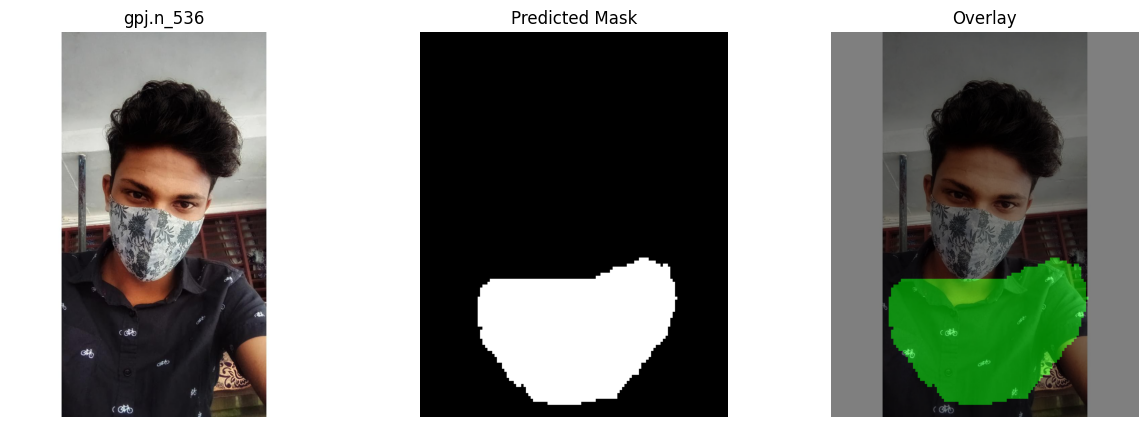

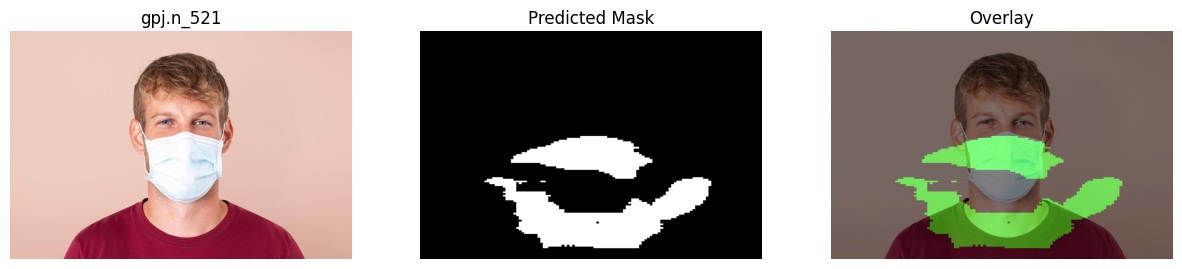

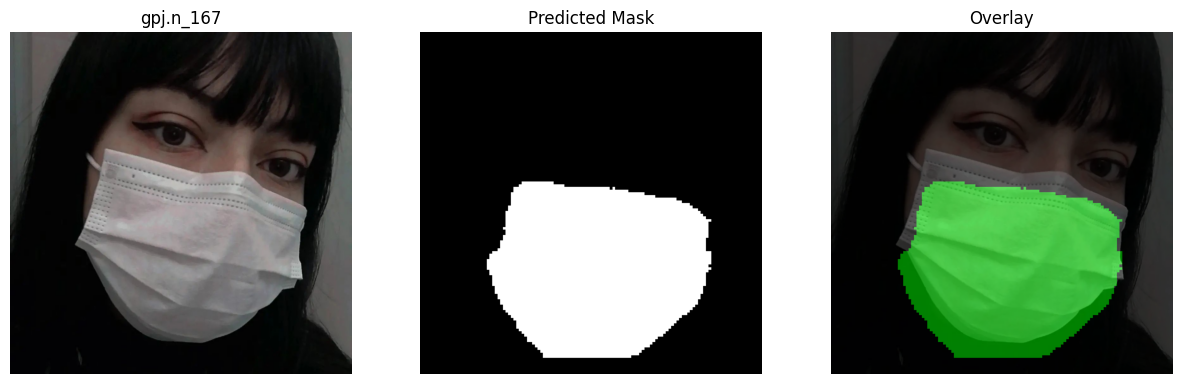

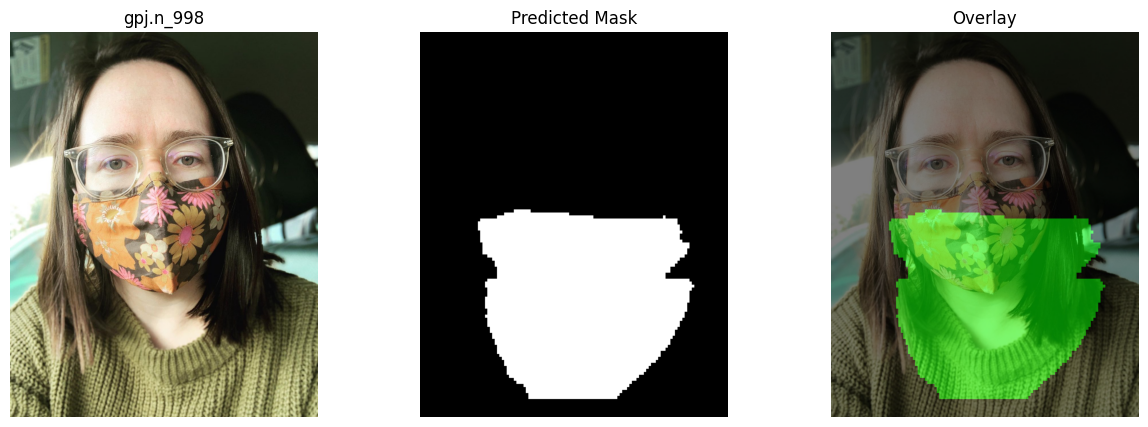

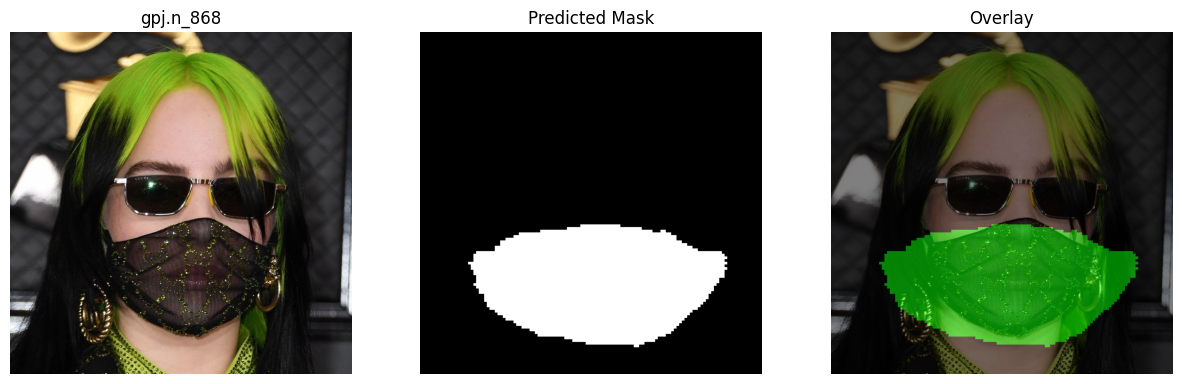

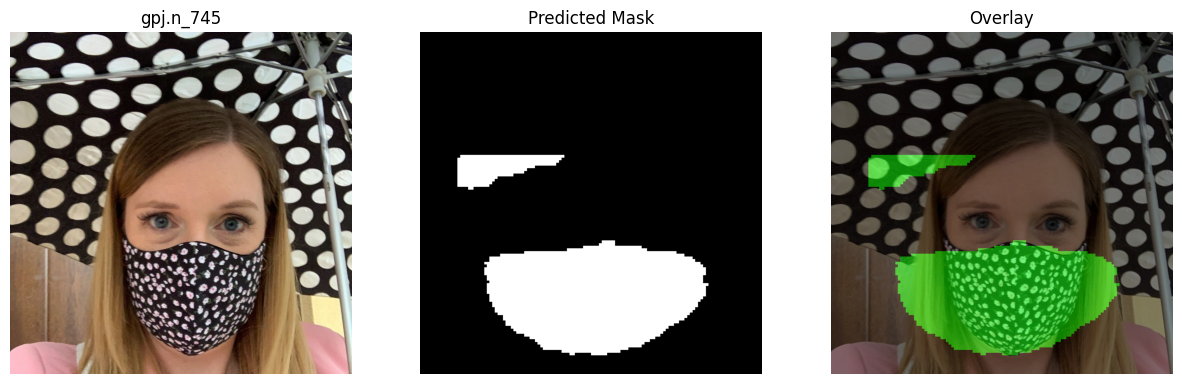

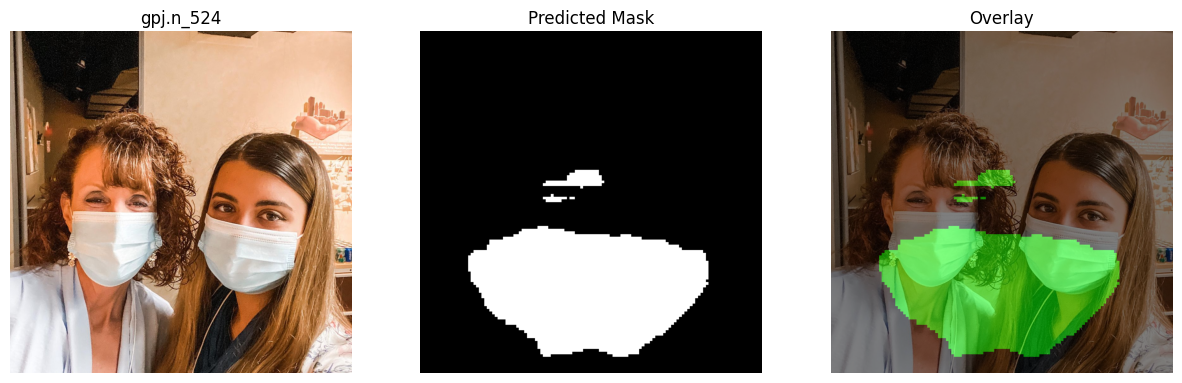

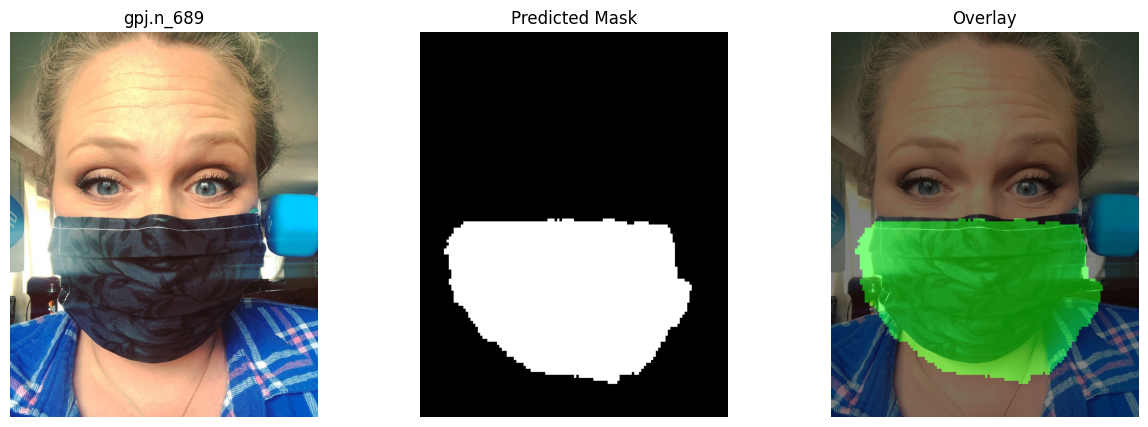

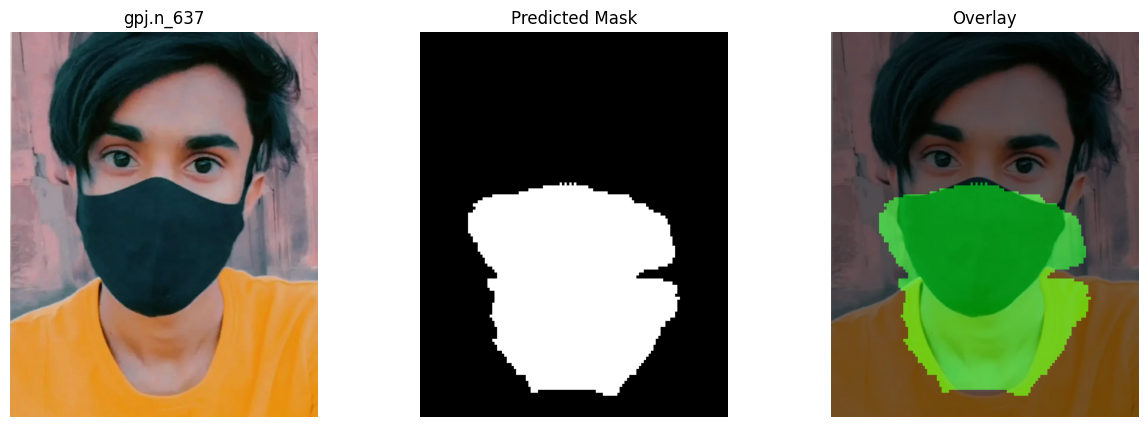

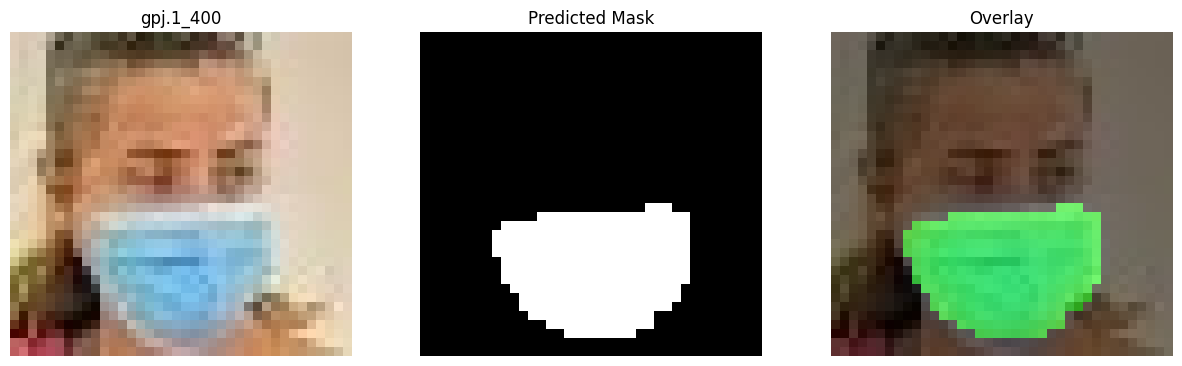

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

# Attention Gate Module
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_l, 1),
            nn.BatchNorm2d(F_l)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_l, 1),
            nn.BatchNorm2d(F_l)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_l, 1, 1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

# Enhanced U-Net Architecture
class EnhancedUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(EnhancedUNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        # Encoder
        self.enc1 = conv_block(in_channels, 48)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(48, 96)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(96, 192)
        self.pool3 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = conv_block(192, 384)
        
        # Decoder with Attention Gates
        self.upconv3 = nn.ConvTranspose2d(384, 192, 2, stride=2)
        self.attn3 = AttentionGate(192, 192)
        self.dec3 = conv_block(384, 192)
        
        self.upconv2 = nn.ConvTranspose2d(192, 96, 2, stride=2)
        self.attn2 = AttentionGate(96, 96)
        self.dec2 = conv_block(192, 96)
        
        self.upconv1 = nn.ConvTranspose2d(96, 48, 2, stride=2)
        self.attn1 = AttentionGate(48, 48)
        self.dec1 = conv_block(96, 48)
        
        self.final = nn.Conv2d(48, out_channels, 1)
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool3(enc3))
        
        # Decoder
        dec3 = self.upconv3(bottleneck)
        dec3 = self.attn3(dec3, enc3)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = self.attn2(dec2, enc2)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = self.attn1(dec1, enc1)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        
        return self.final(dec1)
    
# Function to perform inference
def perform_inference(model, image_path, device, input_size=128):
    # Create the same transforms used during training
    transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    original_image = image.copy()
    
    # Keep original dimensions for later resizing the mask
    original_size = image.size
    
    # Apply transforms
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Perform inference
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        pred_mask = torch.sigmoid(output) > 0.65
    
    # Convert the mask to a numpy array and resize to original dimensions
    pred_mask = pred_mask.squeeze().cpu().numpy().astype(np.uint8) * 255
    pred_mask_image = Image.fromarray(pred_mask)
    pred_mask_image = pred_mask_image.resize(original_size, Image.NEAREST)
    
    return original_image, pred_mask_image

# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Path to your custom image 
# This assumes you've uploaded your test image to Kaggle's input folder
try:
    custom_dataset_path = "/kaggle/input/test-images-for-mask-detection-unet-model"
except:
    try:
        custom_dataset_path = "./test_images"
    except:
        raise Exception("Please provide the path to the custom test images dataset")
    
import glob
all_files=glob.glob(custom_dataset_path+'/*.jpg')

try:
    custom_img_list = all_files[:10]
    print(custom_img_list)
except:
    custom_img_list = all_files
    print(custom_img_list)


# Initialize correct model
model = EnhancedUNet().to(device)

# Load either the best model or final model
try:
    model_path = '/kaggle/input/test-images-for-mask-detection-unet-model/UNET_2.pth'  # or use 'final_model.pth'
except:
    try:
        model_path = './checkpoints/best_model.pth'
    except:
        raise Exception("Please provide the path to the UNET model")

# Load checkpoint
checkpoint = torch.load(model_path, map_location=device)

# Handle different save formats
state_dict = checkpoint.get('model_state_dict', checkpoint)  # Works with both formats

# Remove DataParallel prefixes if needed
if any(k.startswith('module.') for k in state_dict):
    state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}

# Load weights
model.load_state_dict(state_dict)
model.eval()


# Perform inference
for custom_img in custom_img_list:
    original_image, pred_mask = perform_inference(model, custom_img, device)
    
    # Create a blended visualization
    original_array = np.array(original_image)
    mask_array = np.array(pred_mask)
    
    # Create RGB mask for overlay
    mask_rgb = np.zeros_like(original_array)
    mask_rgb[:,:,1] = mask_array  # Green channel for the mask
    
    # Blend the images (50% original, 50% mask)
    alpha = 0.5
    blended = (original_array * alpha + mask_rgb * (1-alpha)).astype(np.uint8)
    
    # Plot the results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.title(custom_img[-1:-10:-1])
    plt.imshow(original_image)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(blended)
    plt.axis('off')

# plt.tight_layout()
# plt.savefig('/kaggle/working/inference_result.png')
# plt.show()

# print("Inference completed and visualization saved to 'inference_result.png'")

